## Import all required libraries

In [1]:
import ixmp
import message_ix
import numpy as np
import pandas as pd
import yaml

from collections.abc import Mapping
from itertools import repeat
from message_ix.models import MESSAGE_ITEMS
from message_ix.utils import make_df
from message_ix.tools.add_dac import *

%matplotlib inline

<IPython.core.display.Javascript object>

C:\Users\pratama\Documents\GitHub\MESSAGEix\message_ix\message_ix\reporting\__init__.py:98: FutureWarning: Importing from genno.computations will be deprecated in a future version; use genno.operator instead.
  ("tom:nl-t-yv-ya", (genno.computations.add, "fom:nl-t-yv-ya", "vom:nl-t-yv-ya")),


In [2]:
def plotvars(scenario):
    # CO2 Emission
    emiss = scenario.var("EMISS")
    emiss = emiss.loc[(emiss['type_tec'] == 'all') & 
                      (emiss['node'] == 'World') & 
                      (emiss['emission'] == 'TCE')]
    emiss_plot = emiss[['year','lvl']].set_index(['year']).div(1000)

    # CO2 Removal
    removal = scenario.var("EMISS")
    removal = removal.loc[(removal['type_tec'] == 'all') & 
                          (removal['node'] == 'World') & 
                          (removal['emission'] == 'CO2_storage')]
    removal_plot = removal[['year','lvl']].set_index(['year']).div(1000)

    # CO2 Prices
    CO2Price = (scenario.var("PRICE_EMISSION")
                .loc[scenario.var("PRICE_EMISSION")['type_emission'] == 'TCE'][['year','lvl']]
                .set_index(['year'])).div(1000)
    
    
    plt.figure(figsize=(4,4))
    # Plottings
    plt.plot(emiss_plot, label='CO2 Emission')
    plt.plot(removal_plot, label='CO2 Removal')
    plt.plot(CO2Price, label='CO2 Price')
    
    plt.ylim(-10,40)
    plt.ylabel("thousands of var unit")
    
    plt.legend()
    plt.show()

In [3]:
# REGIONAL CO2 STORAGE POTENTIAL
# read storage potential in GtCO2
potentials = pd.read_excel("storage_by_country.xlsx").set_index("ISO")

# read regional country lists
reg_list_path = "region_code_list.yaml"

with open(reg_list_path, 'r') as file:
    reg_data = yaml.safe_load(file)

# creating R12 potentials dataframe
R12_potential = pd.DataFrame(columns=["Potential"])

for reg in set(reg_data.keys()) - {"World"}:
    val = potentials.loc[reg_data[reg]["child"]]["Potential"].sum()
    R12_potential.loc[reg] = np.round(1000*val/3.667, 3) # convert to MtCO2
    
R12_pot = R12_potential.div(90)

In [4]:
# SSPs and scenarios lists
ssps = ["SSP1","SSP2","SSP3","SSP4","SSP5"]
ssps = ["SSP1","SSP2","SSP5"]
# Parameters for CO2 injection rate scenarios
co2rates = {
    "co2rate1": 0.2,
    "co2rate2": 0.4,
    "co2rate3": 0.6,
    "co2rate4": 0.8,
    "co2rate5": 1.0,
        }
              
max_rate = np.round(15000/3.667,0) # convert MtCO2/y to MtC/y

# Parameters for DAC market penetration rate scenarios
mpens = {
    "mpen1": 0.050,
    "mpen2": 0.075,
    "mpen3": 0.100,
    "mpen4": 0.125,
    "mpen5": 0.150,
        }

# Parameters for CO2 storage availability scenarios
stors = {
#    "stor1": 0.2,
    "stor2": 0.4,
#    "stor3": 0.6,
#    "stor4": 0.8,
#    "stor5": 1.0,
        }

maxfco2storshares = {
    "maxfco2storshare1": 1.00, # max
    "maxfco2storshare2": 0.80, # max
    "maxfco2storshare3": 0.60, # max
    "maxfco2storshare4": 0.40, # max
    "maxfco2storshare5": 0.20, # max
}

minfco2storshares = {
    "minfco2storshare1": 0.10, # min
    "minfco2storshare2": 0.20, # min
    "minfco2storshare3": 0.30, # min
    "minfco2storshare4": 0.40, # min
    "minfco2storshare5": 0.50, # min
}

daccosts ={
    "daccost1":[1.00,0.97,0.96,0.94,0.93,0.92,0.91,0.91,0.90,0.90,0.90,0.90,0.90],
    "daccost2":[1.00,0.92,0.87,0.82,0.79,0.76,0.74,0.72,0.71,0.70,0.70,0.70,0.70],
    "daccost3":[1.00,0.87,0.79,0.70,0.64,0.59,0.56,0.54,0.51,0.51,0.51,0.50,0.50],
    "daccost4":[1.00,0.82,0.70,0.58,0.50,0.43,0.39,0.35,0.32,0.31,0.31,0.30,0.30],
    "daccost5":[1.00,0.77,0.61,0.46,0.36,0.27,0.22,0.16,0.13,0.11,0.11,0.10,0.10],
}

dacenergies ={
    "dacener1":[1.00,0.97,0.96,0.94,0.93,0.92,0.91,0.91,0.90,0.90,0.90,0.90,0.90],
    "dacener2":[1.00,0.92,0.87,0.82,0.79,0.76,0.74,0.72,0.71,0.70,0.70,0.70,0.70],
    "dacener3":[1.00,0.87,0.79,0.70,0.64,0.59,0.56,0.54,0.51,0.51,0.51,0.50,0.50],
    "dacener4":[1.00,0.82,0.70,0.58,0.50,0.43,0.39,0.35,0.32,0.31,0.31,0.30,0.30],
    "dacener5":[1.00,0.77,0.61,0.46,0.36,0.27,0.22,0.16,0.13,0.11,0.11,0.10,0.10],
}



## Create baseline and emission bound scenarios with split CO2 infrastructure

# Storage test

-------- SSP5 runs --------
DAC 1000f|Split CO2 infrastructure


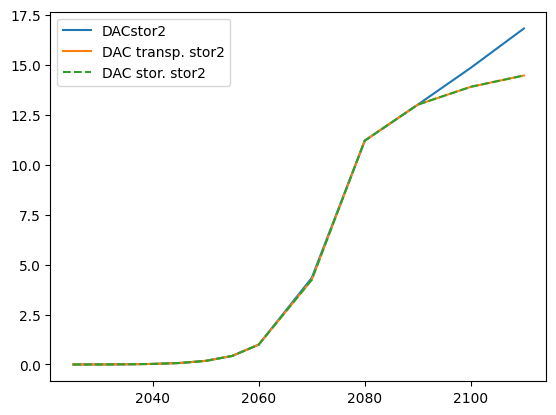

In [5]:
# CONNECT TO DATABASE
mp = ixmp.Platform()

dactec = ['dac_lt','dac_ht']

ssps = ["SSP5"]    
for ssp in ssps:
    for key,val in stors.items():
        print(f"-------- {ssp} runs --------")
        # CREATE 1000f SCENARIO
        base = message_ix.Scenario(mp,
            model=f"SSP_dev_{ssp}_v0.1_dac",
            scenario="1000f_v0.14_default",
        )

        years = [year for year in base.set("year") if year >= 2025]


        scen = base.clone(
            f"SSP_dev_{ssp}_v0.1_dac",
            f"1000f_v0.14_default_{key}",
            f"dac 1000f {key}",
            keep_solution=False, 
        )
        scen.check_out()
    
        # adding set up for limiting storage volume
        if "CO2_storage" not in scen.set("emission"):
            scen.add_set("emission", "CO2_storage")
        if "co2_stor_pot" not in scen.set("type_emission"):
            scen.add_set("type_emission", "co2_storage_pot")
        if "co2_potential" not in scen.set("type_tec"):
            scen.add_set("type_tec", "co2_potential")
        if "co2_stor" not in scen.set("technology"):
            scen.add_set("technology", "co2_stor")

        scen.add_set("cat_emission", ["co2_storage_pot", "CO2_storage"])
        scen.add_set("cat_tec", ["co2_potential", "co2_stor"])
        
        # Updating storage volume limits
        nodes = [node for node in base.set("node") if node not in ["R12_GLB","World"]]
        df_list = []
        for node in nodes:
            df = make_df("bound_emission",
                         node=node,
                         type_emission="co2_storage_pot",
                         type_tec="co2_potential",
                         type_year="cumulative",
                         value = R12_pot.loc[node,"Potential"],
                         unit = "???",
                        )
            df_list = df_list + [df]
        df_stor = pd.concat(df_list)
        df_stor["value"] = df_stor["value"].mul(val) # ultimate potential x fraction
        
        scen.add_par("bound_emission", df_stor)

    
        ## run and report scenario
        scen.commit(comment=f"{ssp}_dev 1000f without DAC scenario")
        scen.set_as_default()

        scen.solve(solve_options={'barcrossalg': '2','scaind':'0'}) # solve_options={'barcrossalg': '2','scaind':'1'}
        scen.var("OBJ")["lvl"]

        # Plotting comparison: DAC activity vs. co2_tr_sd activity
        dac_act = get_values(scen,"ACT").droplevel(["mode","time"])
        dacrem = (dac_act.loc[:, dactec, :, :]["lvl"].unstack().fillna(0)
                   .groupby(["node_loc"]).sum())
        dacrem.loc["World"] = dacrem.sum(axis=0)
        dac_val = dacrem.div(1000).mul(3.667).loc["World"]

        dacpipe = (scen.var("ACT",{"technology":"co2_tr_sd","mode":"M2"})
                   .set_index(["node_loc","technology","year_vtg","year_act","mode","time"])
                   .droplevel(["mode","time"])).mul(3.667).div(1000)
        dacpipe = dacpipe.groupby("year_act").sum()["lvl"]
        dacpipe_val = dacpipe
        
        dacstor = (scen.var("ACT",{"technology":"co2_stor","mode":"M3"})
                   .set_index(["node_loc","technology","year_vtg","year_act","mode","time"])
                   .droplevel(["mode","time"])).mul(3.667).div(1000)
        dacstor = dacstor.groupby("year_act").sum()["lvl"]
        dacstor_val = dacstor


        print("DAC 1000f|Split CO2 infrastructure")
        plt.plot(years,dac_val,label=f"DAC{key}")
        plt.plot(years,dacpipe_val,label=f"DAC transp. {key}")
        plt.plot(years,dacstor_val,label=f"DAC stor. {key}", ls="--")
    
plt.legend()
plt.show()
    

# CLOSE CONNECTION
mp.close_db()